Датасет California Housing Prices содержит информацию о домах, расположенных в определённом округе Калифорнии, а также сводную статистику по ним, основанную на данных переписи 1990 года. Основная цель - предсказание средней стоимости дома в различных кварталах Калифорнии.

Столбцы в датасете: <br>
longitude - Долгота (географическая координата) <br>
latitude - Широта (географическая координата) <br>
housing_median_age - Средний возраст дома в квартале; чем меньше число, тем новее здание <br>
total_rooms - Общее количество комнат в квартале <br>
total_bedrooms - Общее количество спален в квартале <br>
population - Общее количество людей, проживающих в квартале <br>
households - Количество домохозяйств в квартале, то есть групп людей, проживающих в одном жилом помещении, в квартале <br>
median_income - Средний доход домохозяйств в квартале (измеряется в десятках тысяч долларов США) <br>
ocean_proximity - Расположение дома относительно океана/моря <br><br>
median_house_value - Средняя стоимость жилья для домохозяйств в пределах квартала (в долларах США) - целевая переменная. <br>

<br>
1. Загрузка датасета California Housing Prices; первичный анализ.
<br>
Сразу удаляем переменные longitude и latitud, потому что это геоданные, а также ocean_proximity, потому что это категориальный признак.

In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

path = kagglehub.dataset_download("camnugent/california-housing-prices")
file_path = os.path.join(path, "housing.csv")
df = pd.read_csv(file_path, sep=',')


columns_to_drop = ['longitude', 'latitude', 'ocean_proximity']
df = df.drop(columns=columns_to_drop)

print(f"Размер: {df.shape}")
print(df.describe())

c:\Документы\НГТУ\7 семестр\Методы анализа данных\лабы\MAD_lab3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Размер: (20640, 7)
       housing_median_age   total_rooms  total_bedrooms    population  \
count        20640.000000  20640.000000    20433.000000  20640.000000   
mean            28.639486   2635.763081      537.870553   1425.476744   
std             12.585558   2181.615252      421.385070   1132.462122   
min              1.000000      2.000000        1.000000      3.000000   
25%             18.000000   1447.750000      296.000000    787.000000   
50%             29.000000   2127.000000      435.000000   1166.000000   
75%             37.000000   3148.000000      647.000000   1725.000000   
max             52.000000  39320.000000     6445.000000  35682.000000   

         households  median_income  median_house_value  
count  20640.000000   20640.000000        20640.000000  
mean     499.539680       3.870671       206855.816909  
std      382.329753       1.899822       115395.615874  
min        1.000000       0.499900        14999.000000  
25%      280.000000       2.563400    

In [3]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")


Асимметрия:
housing_median_age  :    0.060
total_rooms         :    4.147
total_bedrooms      :    3.459
population          :    4.935
households          :    3.410
median_income       :    1.647
median_house_value  :    0.978

Эксцесс:
housing_median_age  :   -0.801
total_rooms         :   32.623
total_bedrooms      :   21.980
population          :   73.535
households          :   22.052
median_income       :    4.951
median_house_value  :    0.328

Мода:
housing_median_age  : 52.0
total_rooms         : 1527.0
total_bedrooms      : 280.0
population          : 891.0
households          : 306.0
median_income       : 3.125
median_house_value  : 500001.0


2. Визуализация распределения признаков

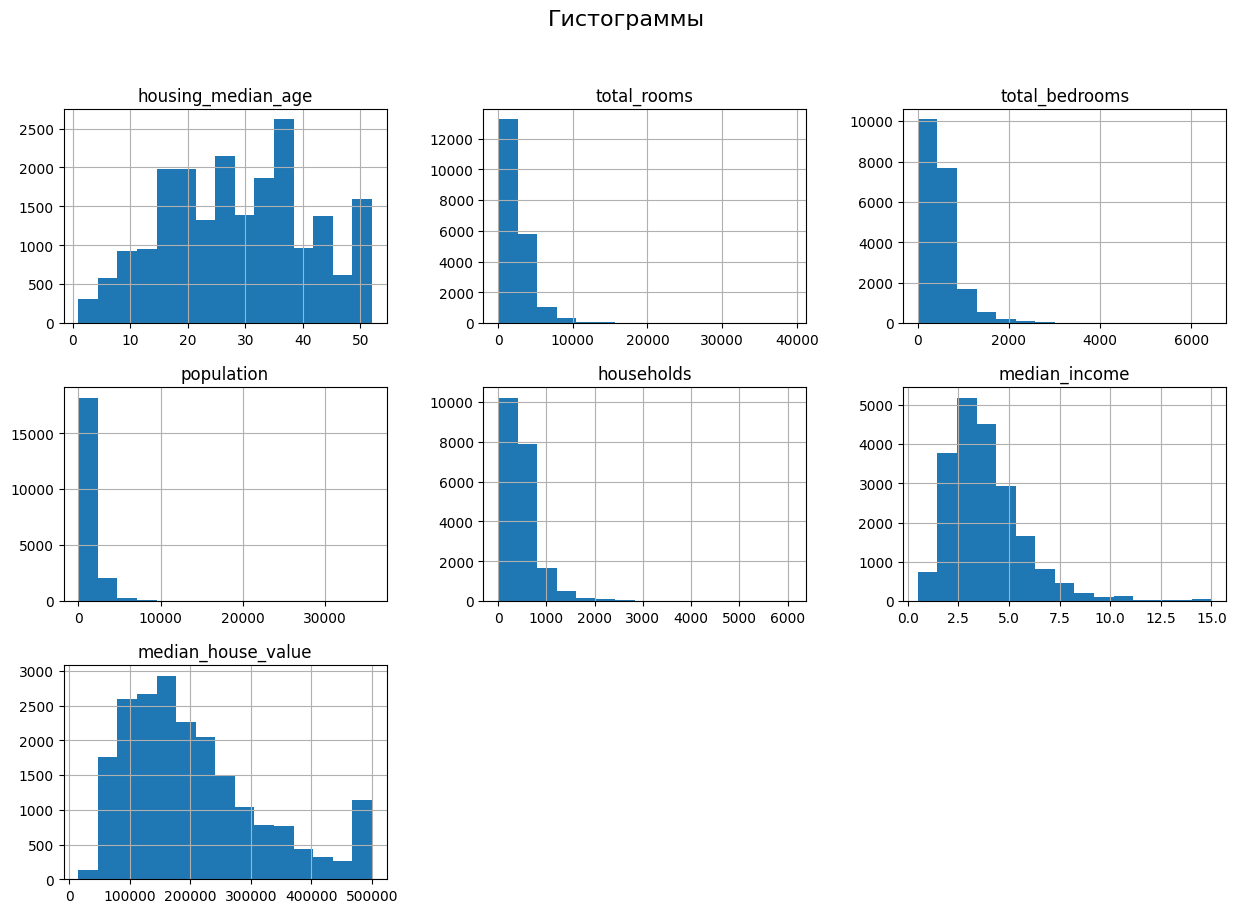

In [4]:
import matplotlib.pyplot as plt
import math

count_intervals = int(1 + math.log2(df.shape[0]))

df.hist(bins=count_intervals, figsize=(15, 10))
plt.suptitle("Гистограммы", fontsize=16)
plt.show()


Анализ распределений<br><br>
2.1 housing_median_age<br>
Ассиметрия: 0.060 - почти нулевая ассиметрия<br>
Эксцесс: -0.801 - плосковершинное распределение<br>
Среднее: 28.64, Медиана: 29.0 - почти совпадают<br>
Итог: распределение близко к нормальному, но не является им.<br><br>
2.2 total_rooms<br>
Ассиметрия: 4.147 - сильно правосторонняя ассиметрия<br>
Эксцесс: 32.623 - островершинное распределение<br>
Среднее: 2635.76, Медиана: 2127 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.3 total_bedrooms<br>
Ассиметрия: 3.459 - сильная правосторонняя ассиметрия<br>
Эксцесс: 21.980 - островершинное распределение<br>
Среднее: 537.87, Медиана: 435 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.4 population<br>
Ассиметрия: 4.935 - очень сильная правосторонняя ассиметрия<br>
Эксцесс: 73.535 - островершинное распределение<br>
Среднее: 1425.48, Медиана: 1166 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.5 households<br>
Ассиметрия: 3.410 - сильная правосторонняя ассиметрия<br>
Эксцесс: 22.052 - островершинное распределение<br>
Среднее: 499.54, Медиана: 409 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.6 median_income<br>
Ассиметрия: 1.647 - умеренная правосторонняя ассиметрия<br>
Эксцесс: 4.951 - островершинное распределение<br>
Среднее: 3.87, Медиана: 3.53 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.7 median_house_value<br>
Ассиметрия: 0.978 - умеренная правосторонняя ассиметрия<br>
Эксцесс: 0.328 - распределение близко к нормальному<br>
Среднее: 206855.82, Медиана: 179700 - среднее > медиана<br>
Итог: распределение близко к нормальному, но не является им.<br>

3. Удаление пропущенных значений

In [11]:
import pandas as pd

df_cleaned = df.replace('?', pd.NA).dropna()

print(f"Исходный размер: {df.shape}")
print(f"Размер после удаления пропущенных значений: {df_cleaned.shape}")

Исходный размер: (20640, 7)
Размер после удаления пропущенных значений: (20433, 7)


5. Построение матрицы корреляций

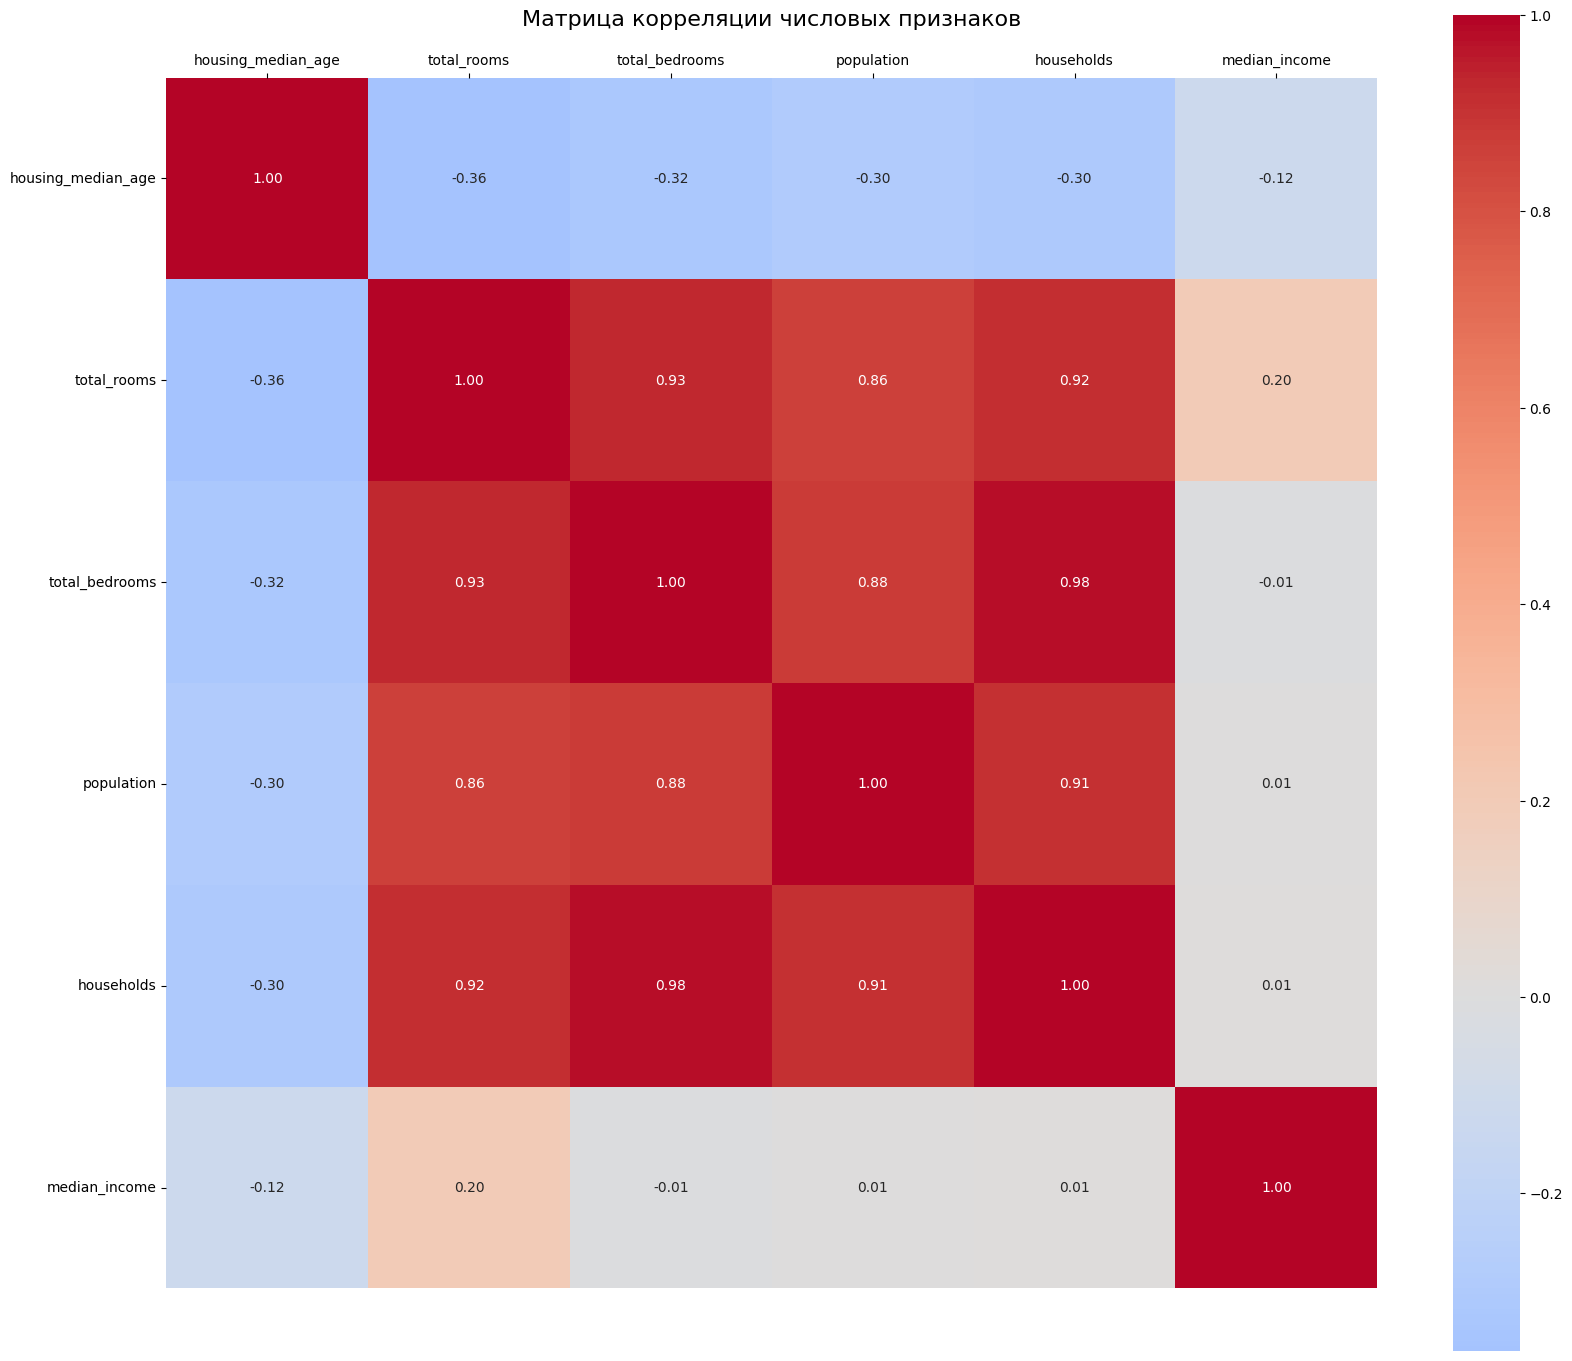


Корреляция с целевой переменной (median_house_value):
median_income: 0.688
total_rooms: 0.133
housing_median_age: 0.106
households: 0.065
total_bedrooms: 0.050
population: -0.025


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(17, 17))

numeric_columns = df_cleaned.select_dtypes(include=['number']).columns
correlation_matrix = df_cleaned[numeric_columns].corr()
correlation_matrix_no_target = correlation_matrix.drop('median_house_value', axis=0).drop('median_house_value', axis=1)


sns.heatmap(correlation_matrix_no_target, 
            annot=True,           
            cmap='coolwarm',      
            center=0,             
            square=True,          
            fmt='.2f',            
            cbar_kws={"shrink": .8},
            xticklabels=correlation_matrix_no_target.columns,  
            yticklabels=correlation_matrix_no_target.columns)  

plt.title('Матрица корреляции числовых признаков', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.xaxis.tick_top()       
ax.xaxis.set_label_position('top')  

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (median_house_value):")
income_corr = correlation_matrix['median_house_value'].sort_values(key=abs, ascending=False)
for feature, corr_value in income_corr.items():
    if feature != 'median_house_value':
        print(f"{feature}: {corr_value:.3f}")

Сильно коррелируемые признаки: <br>
total_bedrooms и households: 0.98 <br>
total_bedrooms и total_rooms: 0.93 <br>
total_rooms и households: 0.92 <br>
households и population: 0.91 <br>
total_bedrooms и population: 0.88 <br>
total_rooms и population: 0.86 <br>
median_income и median_house_value: 0.69 <br>


Формула стандартизации: <br>
z = (x - μ) / σ, где <br>
x - исходное значение <br>
μ - среднее значение признака <br>
σ - стандартное отклонение признака <br>
z - стандартизированное значение

9. Попробуем снизить размерность признаков с помощью метода главных компонент (PCA).

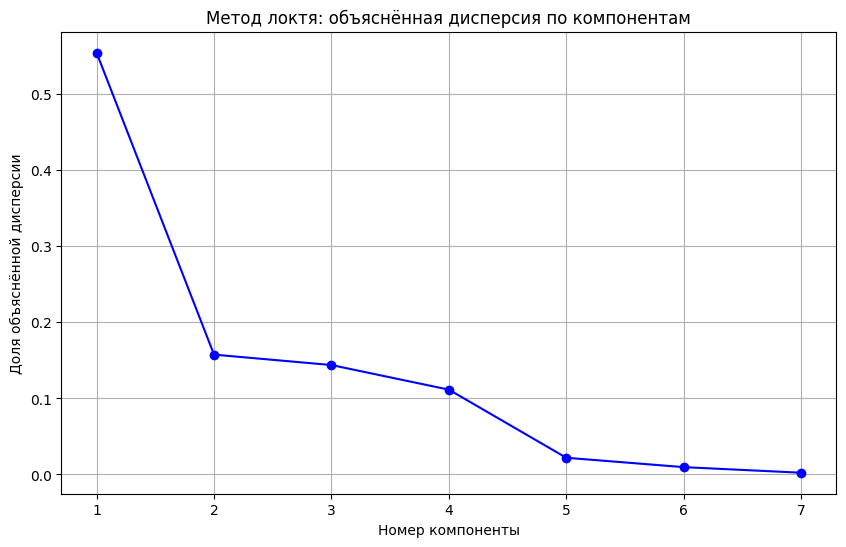

Доля объясненной дисперсии по компонентам:
Компонента 1: 0.5538 (55.38%)
Компонента 2: 0.1574 (15.74%)
Компонента 3: 0.1437 (14.37%)
Компонента 4: 0.1114 (11.14%)
Компонента 5: 0.0219 (2.19%)
Компонента 6: 0.0096 (0.96%)
Компонента 7: 0.0023 (0.23%)

Кумулятивная дисперсия:
Первые 1 компонент(ы): 0.5538 (55.38%)
Первые 2 компонент(ы): 0.7112 (71.12%)
Первые 3 компонент(ы): 0.8548 (85.48%)
Первые 4 компонент(ы): 0.9662 (96.62%)
Первые 5 компонент(ы): 0.9881 (98.81%)
Первые 6 компонент(ы): 0.9977 (99.77%)
Первые 7 компонент(ы): 1.0000 (100.00%)

Оптимальное число компонент для объяснения 95% дисперсии: 4

Размерность до PCA: (16346, 7)
Размерность после PCA: (16346, 4)
Объясненная дисперсия: 0.9662


In [ ]:
from sklearn.decomposition import PCA

features = ['housing_median_age','total_rooms','total_bedrooms','population','households',
            'median_income','ocean_proximity_num']

X = df_cleaned[features]
y = df_cleaned['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объяснённой дисперсии')
plt.title('Метод локтя: объяснённая дисперсия по компонентам')
plt.grid(True)
plt.show()

print("Доля объясненной дисперсии по компонентам:")
for i, ratio in enumerate(pca_full.explained_variance_ratio_):
    print(f"Компонента {i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"\nКумулятивная дисперсия:")
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
for i, cum_var in enumerate(cumsum_var):
    print(f"Первые {i+1} компонент(ы): {cum_var:.4f} ({cum_var*100:.2f}%)")

n_components = np.argmax(cumsum_var >= 0.95) + 1
print(f"\nОптимальное число компонент для объяснения 95% дисперсии: {n_components}")

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nРазмерность до PCA: {X_train_scaled.shape}")
print(f"Размерность после PCA: {X_train_pca.shape}")
print(f"Объясненная дисперсия: {sum(pca.explained_variance_ratio_):.4f}")

Первые 4 компоненты объясняют 96.62% всей информации, а остальные — только 3.38%. Также по графику видно, что происходит резкое падение дисперсии после 1-ой компоненты ( у 1 -ой компоненты доля объясненной дисперсии 55.38%, а у 2-ой в разы меньше - 15.74%), затем более пологий спад до 4-й, а потом — почти горизонтальная линия. Локоть находится примерно на 4-й компоненте — именно там добавление новых компонент перестаёт давать значительный прирост объяснённой дисперсии. Это говорит о том, что добавление 5-й, 6-й, 7-й компонент не даёт существенного прироста информации. <br>Значит, можно уменьшить размерность с 7 до 4 признаков, сохранив практически всю информацию и при этом устранив мультиколлинеарность.